# 라이브러리 임포트

In [273]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import timm #코랩에서 설치필요
from sklearn.metrics import accuracy_score, f1_score
from glob import glob
import os
from tqdm import tqdm

## 추가 import
import random # 파이썬 랜덤모듈, 시드고정


#Augmentation Libraries 임포트
import albumentations as A #  vs torchivision.transforms
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

# Configuration 설정

In [274]:
### YOU NEED TO SET THESE HYPER-PARAMETES ###

epochs = 10
lr = 1e-4
batch_size = 16


#####################################

In [275]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
# cudnn을 사용하는 로컬 환경에서(?)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [276]:
# from google.colab import drive
# drive.mount('/content/drive')

In [277]:
# #data 다운로드
# model_dir = './data'
# os.makedirs(model_dir, exist_ok=True)

# !unzip /content/drive/MyDrive/22.프로젝트/모의경진2차/train.zip -d /content/data  # unzip [FileName] -d(directoryoption)[directorPath]
# !unzip /content/drive/MyDrive/22.프로젝트/모의경진2차/test.zip -d /content/data

In [278]:
# 데이터셋 경로 설정
data_dir = '/Users/b12/Desktop/surpluss/모의2차/dataset'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

# Simple EDA

In [279]:
# 데이터 수량 체크
train_defect_images = glob(train_dir + '/defect_images/*.png')
train_normal_images = glob(train_dir + '/normal_images/*.png')
train_defect_mask_images = glob(train_dir + '/defect_masks/*.png')

print(f'total number of train dataset : {len(train_defect_images) + len(train_normal_images)}, defect : {len(train_defect_images)}, normal : {len(train_normal_images)} , mask : {len(train_defect_mask_images)}')

total number of train dataset : 6820, defect : 30, normal : 6790 , mask : 30


In [280]:
# # 이미지를 OpenCV로 읽기
# image = cv2.imread(train_defect_mask_images[0])
# # 이미지의 해상도 확인
# height, width, channels = image.shape
# print(f"Width: {width}, Height: {height}, Channels: {channels}")

# ### 이거 왜 3채널? -> penCV의 imread 함수는 흑백 이미지를 기본적으로 BGR 채널로 읽습니다. 따라서, 흑백 이미지임에도 불구하고 3개의 채널을 가지게 됩니다.

### Augumentation을 위한 데이터셋

transform 1~4 : 짬뽕 intensity tooo lowwwwwwwwww<br>

In [281]:
transforms1 = A.Compose([
    A.AdvancedBlur(),
    A.OneOf([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)],p=1),
    A.GaussNoise(p=0.5),
    A.OneOf([A.RandomRotate90(), A.Rotate()]),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)
])

In [282]:
transforms2 = A.Compose([
    A.AdvancedBlur(),
    A.HorizontalFlip(p=1),
    A.GaussNoise(p=0.5),
    A.OneOf([A.RandomRotate90(), A.Rotate()]),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)
])

In [283]:
transforms3 = A.Compose([
    A.VerticalFlip(p=1),
    A.GaussNoise(p=0.5),
    A.OneOf([A.RandomRotate90(), A.Rotate()]),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
])

In [284]:
#No Flip,
transforms4 = A.Compose([
    A.AdvancedBlur(),
    A.OneOf([A.RandomRotate90(), A.Rotate()]),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
])

In [285]:
#Blur + /Rotation,Flip/ + /Affine/Perspectie/ + /Distrotns, Elastictransform/ RandomGridShuffle / Noise
######## 단일 transforms 의 intensity 는 높게 해야죠

transforms5 = A.ZoomBlur (max_factor=1.15, step_factor=(0.02, 0.03), always_apply=False, p=1)
transforms6 = A.VerticalFlip(p=1.0)
transforms7 = A.HorizontalFlip(p=1.0)
transforms8 = A.GlassBlur(sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=1)
transforms9 = A.GaussNoise (var_limit=(30.0, 50.0), mean=100, per_channel=True, always_apply=False, p=1)
transforms10 = A.Compose([A.Affine(scale=(0.5, 2), p=1)])
transforms11 = A.Perspective(p=1)
transforms12 = A.Rotate(p=1)
transforms13 = A.Sharpen(alpha=(0.5, 1.0), lightness=(0.5, 1.0), always_apply=False, p=1)
transforms14 = A.RandomGridShuffle(grid =(5,5) ,always_apply = False , p =1)
transforms15 = A.OpticalDistortion(distort_limit=3, shift_limit=0.05, p=1, border_mode=cv2.BORDER_CONSTANT, value=0)
transforms16 = A.GridDistortion(num_steps=50, distort_limit=0.8, p=1, border_mode=cv2.BORDER_CONSTANT, value=0)
transforms17 = A.AdvancedBlur(blur_limit=(7, 15),p=1)
transforms18 = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, border_mode=cv2.BORDER_CONSTANT, value=0)
transforms19 = A.RandomGridShuffle(p=1)
transforms20 = A.GlassBlur(sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=1)
transforms21 = A.MotionBlur(blur_limit=23, allow_shifted=True, always_apply=False, p=1)
transforms22 = A.CoarseDropout(max_holes = 25 , max_height = 12 , max_width = 12 , min_holes = 15 ,
min_height = None , min_width = None , fill_value = 0 , always_apply = False , p = 1 )
transforms23 = A.Blur()

1Blur, sharpen<br>
2Rotation,Flip<br>
3Affine <br>
4Distortions, Elastictransform<br>
5RandomGridShuffle / Noise<br>
6:Optional: Perspective , RandomGamma

In [286]:
transforms24 = A.Compose([
    A.Blur(p=1),
    A.Rotate(),
    A.OneOf([A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)])
])

In [287]:
transforms25 = A.Compose([
 #   A.Sharpen(alpha=(0.3, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1),
    A.VerticalFlip(p=1.0),
    A.RandomGamma(p=1,gamma_limit=(100, 255)),
    A.OneOf([A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
             A.OpticalDistortion(distort_limit=0.2, shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)],p=1)
])

In [288]:
transforms26 = A.Compose([
    A.Sharpen(alpha=(0.5, 1.0), lightness=(0.5, 1.0), always_apply=False, p=1),
    A.HorizontalFlip(p=1.0),
    A.OneOf([A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
             A.OpticalDistortion(distort_limit=0.2, shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)],p=1)
])

In [289]:
transforms27 = A.Compose([
    A.Rotate(),
    A.OneOf([A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),],p=1),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0)
])

In [290]:
##실험수정
transforms28 = A.Compose([
    A.GaussNoise(p=0.5,var_limit=(210.0, 250.0)),
    A.Rotate(p=0.5),
    A.RandomGamma(),
    A.Affine(scale=(0.5, 2), p=1)#, mode=cv2.BORDER_CONSTANT)
])

In [291]:
transforms29 = A.Compose([
    A.GaussNoise(p=0.5),
    A.AdvancedBlur(blur_limit=(7, 15),p=1),
    A.RandomGridShuffle(grid =(3,3) ,always_apply = False , p =1)
])

In [292]:
transforms30 = A.Compose([
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=1,gamma_limit=(100, 255)),
    A.OneOf([A.HorizontalFlip(p=1), A.VerticalFlip(p=1)],p=1),
    A.RandomGridShuffle(grid =(3,3) ,always_apply = False , p =1)
])

In [293]:
transforms31 = A.Compose([
    A.RandomGridShuffle(grid =(3,3) ,always_apply = False , p =1),
    A.OneOf([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)],p=1),
    A.Perspective()
])

In [294]:
transforms32 = A.Compose([
    A.Affine(scale=(0.5, 2), p=1),
    A.RandomGridShuffle(grid =(3,3) ,always_apply = False , p =1),
    A.OneOf([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)],p=1),
])

In [295]:
transforms33 = A.Compose([
    A.CoarseDropout(max_holes = 25 , max_height = 12 , max_width = 12 , min_holes = 15 ,
min_height = None , min_width = None , fill_value = 0 , always_apply = False , p = 1 ),
    A.GridDistortion(num_steps=100, distort_limit=1, p=1)

])


In [296]:
transforms34 = A.Compose([
    A.CoarseDropout(max_holes = 25 , max_height = 12 , max_width = 12 , min_holes = 15 ,
min_height = None , min_width = None , fill_value = 0 , always_apply = False , p = 1 ),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.2, p=1, border_mode=cv2.BORDER_CONSTANT, value=0)

])

In [297]:
transforms35 = A.Compose([
    A.Rotate(),
    A.Blur(),
    A.RandomGridShuffle(grid =(3,3) ,always_apply = False , p =1),
    A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, border_mode=cv2.BORDER_CONSTANT, value=0)
])

In [298]:
transforms36 = A.Compose([
    A.RandomGamma(p=1,gamma_limit=(50, 200)),
    A.OneOf([A.OpticalDistortion(distort_limit=2, shift_limit=0.2, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),
             A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, border_mode=cv2.BORDER_CONSTANT, value=0),
             A.GridDistortion(num_steps=100, distort_limit=1, p=1, border_mode=cv2.BORDER_CONSTANT, value=0)]),
])

In [299]:
transforms37 = A.GridDropout(p=1)
transforms38 = A.Resize(height=224, width=224,p=1)
transforms39 = A.Compose([
    A.GaussNoise(),
    A.RandomGamma(),
    A.GaussNoise(p=0.5)
])
transforms40 = A.Compose([
    A.MotionBlur(),
    A.Resize(128,128),
    A.RandomGridShuffle()
])
transforms41 = A.Compose([
    A.GlassBlur(),
    A.Rotate(),
    A.GridDropout()
])
transforms42 = A.Compose([
    A.GridDistortion(border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Resize(224,224),
    A.CoarseDropout()
])
transforms43 = A.Compose([
    A.OpticalDistortion(border_mode=cv2.BORDER_CONSTANT, value=0),
    A.CoarseDropout()
])
transforms44 = A.Compose([
    A.MotionBlur(),
    A.Resize(256,256),
    A.RandomGridShuffle()
])
transforms45 = A.Compose([
    A.RandomGamma(),
    A.GaussNoise(p=0.5),
    A.Perspective()
])
transforms46 = A.Compose([
    A.HorizontalFlip(),
    A.Resize(224,224)
])
transforms47 = A.Compose([
    A.Resize(488,488),
    A.RandomGridShuffle()
])

transforms48 = A.Compose([
    A.Resize(224,224),
    A.VerticalFlip(),
    A.GridDropout()
])

transforms49 = A.Compose([
    A.Resize(112,112),
    A.Affine(scale=(0.5, 2), p=1)
])

transforms50 = A.Compose([
    A.ElasticTransform(border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Resize(312,312),
])
transforms51 = A.Compose([
    A.MotionBlur(),
    A.CoarseDropout(),
    A.OpticalDistortion(border_mode=cv2.BORDER_CONSTANT, value=0)

])

transforms52 = A.Compose([
    A.GlassBlur(),
    A.Resize(312,312),
    A.GridDistortion(border_mode=cv2.BORDER_CONSTANT, value=0)
])


transforms53 = A.Compose([
    A.Sharpen(),
    A.Rotate(),
    A.GaussNoise(p=0.5),
])

transforms54 = A.Compose([
    A.MotionBlur(),
    A.GaussNoise(p=0.5),
    A.Rotate(),
    A.Affine(scale=(0.5, 2), p=1)
])

In [300]:
#######################################

In [301]:
cv2.imread(train_defect_images[1])

array([[[ 26,  26,  26],
        [ 76,  76,  76],
        [ 77,  77,  77],
        ...,
        [ 98,  98,  98],
        [ 96,  96,  96],
        [ 13,  13,  13]],

       [[ 71,  71,  71],
        [147, 147, 147],
        [143, 143, 143],
        ...,
        [186, 186, 186],
        [161, 161, 161],
        [ 83,  83,  83]],

       [[ 78,  78,  78],
        [158, 158, 158],
        [141, 141, 141],
        ...,
        [190, 190, 190],
        [175, 175, 175],
        [ 79,  79,  79]],

       ...,

       [[ 68,  68,  68],
        [136, 136, 136],
        [150, 150, 150],
        ...,
        [148, 148, 148],
        [149, 149, 149],
        [ 63,  63,  63]],

       [[ 69,  69,  69],
        [151, 151, 151],
        [151, 151, 151],
        ...,
        [166, 166, 166],
        [156, 156, 156],
        [ 71,  71,  71]],

       [[ 25,  25,  25],
        [ 68,  68,  68],
        [ 77,  77,  77],
        ...,
        [ 80,  80,  80],
        [ 72,  72,  72],
        [ 14,  14,  14]]

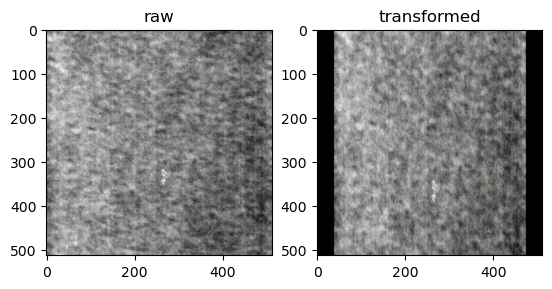

In [302]:
#### TEST BLOCK #####
transform99 = transforms28#A.GaussNoise(p=1)#,var_limit=(100.0, 500.0))

#### transform 실행
temp_img = train_defect_images[5]
#cv2.imsread(temp_img)
transformed_one= transform99(image=cv2.imread(train_defect_images[5]))
plt.figure()
plt.subplot(1,2,1)
plt.title('raw')
plt.imshow(cv2.imread(temp_img))
plt.subplot(1,2,2)
plt.title('transformed')
plt.imshow(transformed_one['image'])

In [ ]:
# 이미지 데이터 추출
transformed_image = transformed_one['image']

# 음수값이 있는 위치 찾기
negative_positions = np.where(transformed_image < 0)

# 음수값의 인덱스와 해당 값 출력
for idx in zip(*negative_positions):
    print(f"Index: {idx}, Value: {transformed_image[idx]}")


In [ ]:
#### TEST BLOCK #####
transform99 = A.RandomGamma(p=1,gamma_limit=(100, 255))

#### transform 실행
temp_img = train_defect_images[5]
#cv2.imsread(temp_img)
transformed_one= transform99(image=cv2.imread(train_defect_images[5]))
plt.figure()
plt.subplot(1,2,1)
plt.title('raw')
plt.imshow(cv2.imread(temp_img))
plt.subplot(1,2,2)
plt.title('transformed')
plt.imshow(transformed_one['image'])


# Pytorch CustomDataset 클래스 정의

In [305]:
label1 = [1] * len(train_defect_images)

In [306]:
## 데이터 전처리 고도화 작업 필요
class Aug(Dataset):
    def __init__(self, image_paths, labels, transforms= None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms  ################ Augumentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        if isinstance(image_path, str):  # 문자열인 경우, 파일 경로로 판단
            image= cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        elif isinstance(image_path, np.ndarray):  # 넘파이 배열인 경우, 이미지 데이터로 판단
            image = image_path

        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #IMREAD_GRAYSCALE 안쓰면 어차피 흑백이미지면   IMREAD_COLOR
        image = image / 255.0 #scailing

        if self.transform:
            transformed = self.transform(image=image) #torch VS Albu
            image = transformed['image']

        label = self.labels[idx]
        return image, label

In [307]:
class TestDataset(Dataset):
    def __init__(self, image_paths, labels, transforms= None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms  ################ Augumentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        if isinstance(image_path, str):  # 문자열인 경우, 파일 경로로 판단
            image= cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        elif isinstance(image_path, np.ndarray):  # 넘파이 배열인 경우, 이미지 데이터로 판단
            image = image_path

        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #IMREAD_GRAYSCALE 안쓰면 어차피 흑백이미지면   IMREAD_COLOR
        image = image / 255.0 #scailing

        if self.transform:
            image = self.transform(image=image) #torch VS Albu

        label = self.labels[idx]
        return image, label

In [308]:
aug_dict = {}
for i in range(1, 55): # 1 to 58 inclusive
    transform_var = f'transforms{i}'
    try:
        aug_dict[i] = Aug(train_defect_images, label1, locals()[transform_var])
    except KeyError:
        print(f"Variable {transform_var} does not exist!")
    except Exception as e:
        print(f"Error while creating Aug for i={i}: {e}")


In [309]:
from torch.utils.data import ConcatDataset

datasets = [aug_dict[i] for i in range(1, 55)]

Aug_set = ConcatDataset(datasets)

In [310]:
label0 = [0] * len(train_normal_images)

In [311]:
#기본 Raw이미지도 추가
Raw_defectset = TestDataset(train_defect_images,labels=label1,transforms=None)

In [312]:
#Normal Image
Normal_set = TestDataset(train_normal_images, labels = label0, transforms=None)

Aug_set / Raw_defectset / Normal_set

# Total Train /Test split

In [313]:
def collate_fn(batch):
    # batch는 (image, label) 쌍의 리스트입니다.
    images, labels = zip(*batch)

    # 이미지들의 크기 중 가장 큰 크기를 구합니다.
    max_height = max([img.shape[0] for img in images])
    max_width = max([img.shape[1] for img in images])

    # 패딩된 이미지를 저장할 리스트를 생성합니다.
    padded_images = []
    for img in images:
        # 각 이미지를 max_height, max_width에 맞게 패딩합니다.
        padding = ((0, max_height - img.shape[0]),
                   (0, max_width - img.shape[1]))
        padded_img = np.pad(img, padding, mode='constant', constant_values=0)
        padded_images.append(padded_img)

    # 이미지와 레이블을 텐서로 변환합니다.
    images_tensor = torch.stack([torch.tensor(img) for img in padded_images], 0)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    return images_tensor, labels_tensor



In [314]:
total_dataset = ConcatDataset([Aug_set, Raw_defectset, Normal_set])


# 전체 라벨 목록을 생성합니다.
total_label = (label1*55) + label0

indices = list(range(len(total_dataset)))

# train_test_split을 사용하여 데이터의 인덱스를 분할합니다.
train_indices, val_indices, _, _ = train_test_split(
    indices, total_label, test_size=0.3, random_state=42, stratify=total_label
)

# 분할된 인덱스를 사용하여 torch.utils.data.Subset으로 실제 Dataset을 생성합니다.
train_subset = Subset(total_dataset, train_indices)
val_subset = Subset(total_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False, collate_fn=collate_fn)
test_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False, collate_fn=collate_fn)


<Figure size 1800x1200 with 0 Axes>

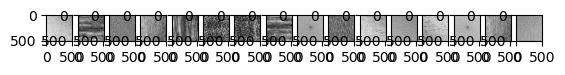

In [315]:
# 데이터 샘플 체크
plt.figure(figsize=(18,12))
for batch in train_loader:
    imgs, labels = batch
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 총 사진의 개수만큼 plot

    for i, img in enumerate(imgs):
        axs[0, i].imshow(img.squeeze(), cmap='gray')

    break

# CNN Model 정의 (resnet18d)

In [316]:
#pretrained_model_list = timm.list_models(pretrained=True)
#pretrained_model_list

In [317]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder =  timm.create_model('efficientnet_b5', pretrained=True, in_chans=1)
        #self.encoder = timm.models.vit_base_patch16_224(pretrained=True).to(device)
        #self.encoder =  timm.create_model('resnet18d', pretrained=True, in_chans=1)
        # self.encoder =  timm.create_model('resnet34d', pretrained=True, in_chans=1)

        self.head = nn.Linear(1000, 1) #1000 : 모델마다 따른 head수치 but ImageNet-based , timm은 대부분 1000개의 분류를 사용하였음

    def forward(self, image, mode='train'):
        x = self.encoder(image)
        output = self.head(x)
        output = torch.sigmoid(output)   #-> (8,1) 확률값
        return output

using DropOut in head

In [318]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.encoder = timm.create_model('efficientnet_b4', pretrained=True, in_chans=1)

#         self.head = nn.Sequential(
#             nn.Linear(1000, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1)
#         )

#     def forward(self, image, mode='train'):
#         x = self.encoder(image)
#         output = self.head(x)
#         output = torch.sigmoid(output)
#         return output

In [319]:
#print(Net())

# 모델, Loss, Optimizer 선언

In [320]:
model = Net()
model = model.to(device)

criterion = nn.BCELoss()
# weight = len(train_normal_images)/len(Augs_defect_images)
# criterion = nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=torch.tensor(weight))
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1, verbose=False)

# 학습 모델 저장 경로 설정

In [321]:
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

# 학습 및 검증

In [322]:
train_subset[240]

(array([[0.09019608, 0.31372549, 0.32156863, ..., 0.36470588, 0.31372549,
         0.10588235],
        [0.29411765, 0.63137255, 0.62352941, ..., 0.72156863, 0.67058824,
         0.36078431],
        [0.29411765, 0.63529412, 0.61176471, ..., 0.72941176, 0.72156863,
         0.36470588],
        ...,
        [0.29803922, 0.60392157, 0.58039216, ..., 0.64313725, 0.61568627,
         0.26666667],
        [0.30196078, 0.61568627, 0.63137255, ..., 0.60784314, 0.6       ,
         0.31764706],
        [0.07843137, 0.32941176, 0.32156863, ..., 0.2627451 , 0.26666667,
         0.03529412]]),
 1)

In [323]:
# # Tensor NaN코드

# for idx in range(len(train_subset)):
#     data, label = train_subset[idx]
#     data = torch.tensor(data)  # numpy 배열을 Tensor로 변환
#     label = torch.tensor(label)  # numpy 배열을 Tensor로 변환

#     if torch.isnan(data).any():
#         print(f"Found NaN in data at index {idx}!")
#     if torch.isnan(label).any():
#        print(f"Found NaN in label at index {idx}!")


In [324]:
# # 문제가 발생한 train_subset의 인덱스들
# problem_indices = [240, 337, 346, 407, 578, 741, 798, 1075, 2604, 2924, 3171, 3537, 3539, 
#                    3592, 4183, 5324, 5429, 5554, 5655, 5666, 5806]

# # train_subset에서 원래의 total_dataset 인덱스를 찾습니다.
# original_indices = [train_indices[idx] for idx in problem_indices]

# # 각 Aug_set의 길이를 구합니다.
# aug_set_length = len(train_defect_images)  # 각 Aug_set의 길이는 동일합니다.

# # 원래 인덱스를 사용해 어느 transform에서 문제가 발생했는지 파악합니다.
# problem_transforms = [(idx // aug_set_length) + 1 for idx in original_indices]

# problem_transforms


[17,
 99,
 24,
 203,
 92,
 164,
 175,
 242,
 117,
 112,
 85,
 21,
 38,
 51,
 235,
 175,
 218,
 253,
 165,
 211,
 117]

In [ ]:
# Train and Valid Loop

metric_best = 0.
model_file = os.path.join(model_dir, f'best.pt')

for epoch in range(epochs):
    # Train Loop
    model.train()  # train mode 설정
    train_loss = 0
    train_outputs = []
    train_labels = []
    for batch in tqdm(train_loader, desc=f'train-{epoch}'):
        imgs, labels = batch

        # NaN 값을 0으로 대체 (Train)
        imgs = torch.where(torch.isnan(imgs), torch.zeros_like(imgs), imgs)
        labels = torch.where(torch.isnan(labels), torch.zeros_like(labels), labels)

        imgs = imgs.to(device).float()
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(imgs.unsqueeze(1))
        loss = criterion(output, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_outputs.append(output.cpu().detach())
        train_labels.append(labels.cpu().detach())

    train_loss /= len(train_loader)

    # Validation Loop
    val_loss = 0
    val_outputs = []
    val_labels = []
    model.eval()  # we use BatchNormalization and dropout
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'val-{epoch}'):
            imgs, labels = batch

            # NaN 값을 0으로 대체 (Validation)
            imgs = torch.where(torch.isnan(imgs), torch.zeros_like(imgs), imgs)
            labels = torch.where(torch.isnan(labels), torch.zeros_like(labels), labels)

            imgs = imgs.to(device).float()
            labels = labels.to(device)

            output = model(imgs.unsqueeze(1))
            loss = criterion(output, labels.unsqueeze(1).float())

            val_loss += loss.item()
            val_outputs.append(output.cpu().detach())
            val_labels.append(labels.cpu().detach())

    val_loss /= len(test_loader)
    train_outputs = (torch.cat(train_outputs) > 0.5).float().squeeze(-1)
    val_outputs = (torch.cat(val_outputs) > 0.5).float().squeeze(-1)
    train_labels = torch.cat(train_labels)
    val_labels = torch.cat(val_labels)

    train_acc = accuracy_score(train_labels, train_outputs)
    val_acc = accuracy_score(val_labels, val_outputs)

    train_f1 = f1_score(train_labels, train_outputs, average='macro')
    val_f1 = f1_score(val_labels, val_outputs, average='macro')

    if val_f1 > metric_best:
        print(f'metric_best ({metric_best:.6f} --> {val_f1:.6f}). Saving model ...')
        torch.save(model.state_dict(), model_file)
        metric_best = val_f1
    scheduler.step()

    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, Train F1: {train_f1}, Val F1: {val_f1}')



val-0: 100%|█████████████████████████████████████████████| 159/159 [53:03<00:00, 20.02s/it]


metric_best (0.000000 --> 0.950148). Saving model ...
Epoch: 0, Train Loss: 0.11425683227386578, Val Loss: 0.562337388440457, Train Acc: 0.9625930941096817, Val Acc: 0.9703791469194313, Train F1: 0.9393169318182504, Val F1: 0.9501477322993604


train-1:  24%|█████████▏                             | 87/370 [2:28:08<8:56:33, 113.76s/it]

# Pytorch CustomTestDataset 클래스 정의

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [ ]:
test_images = glob(test_dir + '/images/*.png')

print(f'the number of test images : {len(test_images)}')

In [ ]:
test_dataset = CustomTestDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

# 학습된 모델 로드

In [ ]:
model_dir = './models'
model_file = os.path.join(model_dir, f'best (1).pt')
model = Net()
model.load_state_dict(torch.load(model_file, map_location=device))
model = model.to(device)

# 추론 수행

In [ ]:
image_names = []
test_outputs = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        imgs, image_name = batch
        imgs = imgs.to(device).float()

        output = model(imgs.unsqueeze(1))
        test_outputs.append(output.cpu().detach())
        image_names.extend(image_name)

test_outputs = (torch.cat(test_outputs) > 0.5).int().squeeze(-1)

# 추론 결과 저장

In [ ]:
test_outputs.numpy().sum()

In [ ]:
submission = pd.DataFrame({'ImageId': image_names, 'answer': test_outputs.tolist()})
submission = submission.sort_values(by=['ImageId']).reset_index(drop=True)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

In [ ]:
submission['answer'].value_counts()

In [ ]:
#############################################

In [ ]:
#구글 드라이브에 저장
#submission.to_csv('/content/drive/MyDrive/22.프로젝트/모의경진2차/submssion1006_1st.csv', index=False)
submission.to_csv('submission.csv', index=False)

In [ ]:
# import time
# print ("Sleep 5 seconds from now on...")
# time.sleep(90)
# print("wake up!")

In [ ]:
# #submission 제출 후 colab연결 끊기 
# from google.colab import runtime
# runtime.unassign()